# RNNs

- Will create a vanilla RNN, LSTM, GRU, and bidirectional rnn layers in Pytorch from scratch without using the built in implementations from torch.nn.</br>
- The Mackey Glass time series dataset will be used, it contains a single time series input.
</br></br>

### Import Data and Libraries
---

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [4]:
data = torch.tensor(pd.read_csv("data.txt", header=None).values)
data.shape

torch.Size([10000, 1])

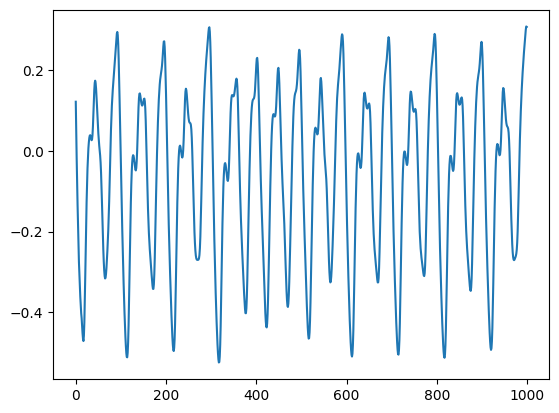

In [5]:
# plots the first 1000 points in the dataset
plt.plot(data[:1000])

In [6]:
CONTEXT_LENGTH = 8
EPOCHS = 20
LEARNING_RATE = 3e-4
BATCH_SIZE = 16
HIDDEN_SIZE = 32
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

</br></br>

### Basic Data Preprocessing
---

</br>

Now will turn the dataset into windows of length 8. These length 8 windows will be used to predict the next '9th' element in the sequence. There will be a window for each index in the dataset, ex: `(data[0]--data[8], data[1]--data[9], ..., data[n - 8]--data[n])`

In [7]:
# Create all the windows for each starting index, each window is a vector of length 8
arr = [data[i:i+CONTEXT_LENGTH] for i in range(len(data) - CONTEXT_LENGTH)]

# horizontally stack each vector and transpose: n x 8
x = torch.hstack(arr).transpose(0, 1)

# offset the y by context length to serve as the 9th target element for each window
y = torch.tensor(data[CONTEXT_LENGTH:len(data)], requires_grad=True)

<ipython-input-7-b6257905c3b4>:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(data[CONTEXT_LENGTH:len(data)], requires_grad=True)


In [8]:
print(x.shape, y.shape)
print(f"\nSequence {list(x[0].numpy())} \nPredicts: {y[0].item()}")

torch.Size([9992, 8]) torch.Size([9992, 1])

Sequence [0.1220639965678425, 0.0471968158986172, -0.018330350400856732, -0.08194957982526882, -0.13422157698005047, -0.18542675204413897, -0.22934343063213447, -0.27547468871792924] 
Predicts: -0.3057978195680628


</br>

Make an 80/20 train test split.

In [9]:
size = int(0.8 * x.shape[0])
X_train = x[:size]
y_train = y[:size]
X_test = x[size:]
y_test = y[size:]

X_train.shape, y_train.shape, X_test.shape, y_test.shape

(torch.Size([7993, 8]),
 torch.Size([7993, 1]),
 torch.Size([1999, 8]),
 torch.Size([1999, 1]))

</br>

`TimeSeriesDataset` will load in the train and test splits and store the respective x and y. It will have a len and getitem function that return the length and the value at an index respectively. Because it inherits from pytorch's Dataset object, it is used to pass into DataLoader which converts the data into batches of size BATCH_SIZE and shuffles the data.

In [10]:
class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = X.to(DEVICE)
        self.y = y.to(DEVICE)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, i):
        return self.X[i], self.y[i]

In [11]:
train_dataset = DataLoader(TimeSeriesDataset(X_train, y_train), BATCH_SIZE, shuffle=True)
test_dataset  = DataLoader(TimeSeriesDataset(X_test, y_test),   BATCH_SIZE, shuffle=True)

In [12]:
print("Train Data Shape: (N, BATCH_SIZE, CONTEXT_SIZE)")

Train Data Shape: (N, BATCH_SIZE, CONTEXT_SIZE)


</br></br>

### Create RNN
---

</br>

Now will actually create the RNN.

`RNNCell`
- $W_{ih}$: Weights used on the input at a particular timestep. Projects the input from input dimension to hidden dimension
- $W_{hh}$: Weights used in the hidden state of the cell. Hidden state is how memory of previous inputs from previous timesteps is preserved. The input at each timestep is factored in with the weighted aggregated of all previous inputs at all preivous timesteps.
- Computes the next hidden state $h_t$ $$h_t = tanh(W_{ih}^Tx_t + b_{ih} + W_{hh}^Th_{t-1} + b_{hh})$$

</br>



In [35]:
class RNNCell(nn.Module):
    def __init__(self, in_dim, hidden_dim, out_dim=1):
      super().__init__()

      # Input weights
      self.Wxh = nn.Linear(in_dim, hidden_dim)

      # Hidden state weights
      self.Whh = nn.Linear(hidden_dim, hidden_dim)


    def forward(self, xt, ht, Ct):
      # Project input to hidden dimension
      xh = self.Wxh(xt)

      # Create new hidden state using input and previous ht
      hidden_state = self.Whh(ht)
      hidden_state = F.tanh(hidden_state + xh)

      return (hidden_state, -1)

</br></br>

`LSTMCell`

</br>

LSTMs solve the vanishing gradient problem that arise in RNNs due to the long cell state that retains information throughout every timestep. This provides a similar advantage like resnets, where there are 2 seperate paths for gradients to flow from the output, one using the short and straight cell state path, and then the longer and complicated short term hidden state path. The cell would accumulate gradients from both paths. If it only took the short term hidden state path, this is the path that contains all the weighted operations and would cause vanishing gradients if the weights are small. But due to the long cell state path, the cell would also accumulate gradients from this long cell state path, thereby making the gradient larger.

</br>

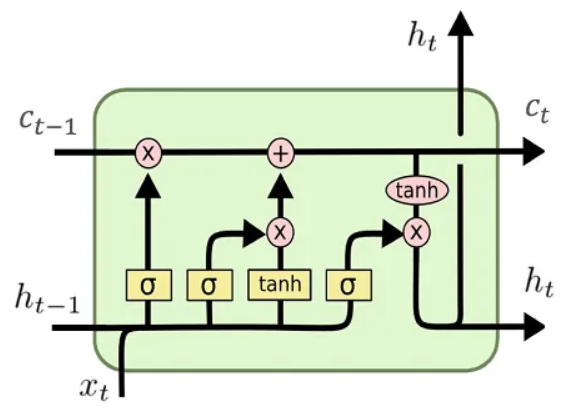

</br>

- $W_f$: Used in the forget gate of the LSTM which controls how much of the running cell state to retain (like forgetting). The cell state after forgetting is computed by the following, where the $x_t$ and $h_t$ are stacked. $$C^{(t)} = C^{(t)} \cdot \sigma(W_f^T[x_t;h_t] + b_f)$$
</br>
- $W_i$: Used to compute the input gate for the modified long term memory state using the current input and short term hidden state (like adding a memory to long term). The input gate computes how much of the new memory should be factored into the long term memory and is computed by the following, where the sigmoid would make the factor between 0 and 1. $$i_t = \sigma(W_{i}^T[x_t;h_t] + b_{i})$$
</br>
- $W_c$: Used to compute the candidate values for the modified long term memory state using the current input and short term hidden state. The candidate value is the potential memory to be added to the long term and is computed by the following, where the tanh encodes the memory to values between -1 and 1. The new cell state is also computed so that the factored memory is added to long term.  $$C_{cand} = \tanh(W_{c}^T[x_t;h_t] + b_{c})$$ $$C_t = i_t \cdot C_{cand}$$
</br>
- $W_o$: Used to compute the output of the cell, or in other words, used to compute the new short term memory for the next time step. $$h_t = \sigma(W_o^T[x_t;h_t] + b_o) \cdot \tanh(C_t)$$

In [36]:
class LSTMCell(nn.Module):
    def __init__(self, in_dim, hidden_dim, out_dim=1):
        super().__init__()
        self.Wf = nn.Linear(HIDDEN_SIZE + 1, HIDDEN_SIZE)
        self.Wi = nn.Linear(HIDDEN_SIZE + 1, HIDDEN_SIZE)
        self.Wc = nn.Linear(HIDDEN_SIZE + 1, HIDDEN_SIZE)
        self.Wo = nn.Linear(HIDDEN_SIZE + 1, HIDDEN_SIZE)

    def forward(self, xt, ht, Ct):
        batch_size = xt.shape[0]
        input = torch.hstack([xt, ht.expand(batch_size, -1)])

        # Forget Gate
        xh = self.Wf(input)
        forget_factor = F.sigmoid(xh)
        Ct_1 = Ct * forget_factor

        # Long Term Memory Addition
        new_mem_to_lt = F.sigmoid(self.Wi(input)) * F.tanh(self.Wc(input))
        Ct_2 = Ct_1 + new_mem_to_lt

        # New Short Term Memory
        ht_new = F.tanh(Ct_2) * F.sigmoid(self.Wo(input))

        return (ht_new, Ct_2)

</br></br>

`GRUCell`

</br>

GRU's are designed in such a way that simplifies the architecture present in the LSTM. Mainly, it removes the need for a seperate hidden and long term cell state, and involves fewer gates when computing the cell output. Though it is simpler in nature, it does not sacrifice overall performance and retains the advantages present in LSTMs, such as solving the vanishing gradient problem, as well as aiding in maintaing long term dependency information.

</br>

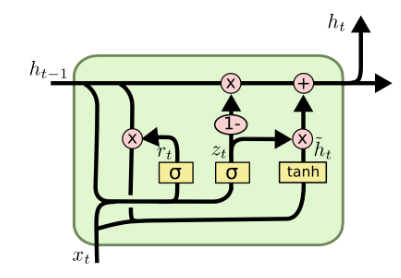

</br>

- $W_r$: Used in the reset gate to compute how much of the hidden state to incorporate. The output of this is the new hidden state after removing information, and will be used to compute the new candidate vector. $$r_{(t)} = \sigma(W_r^T[x_t;h_t] + b_r)$$
</br>
- $W_z$: Used in the update gate to compute how much of the new candidate state will update the previous hidden state. $$r_{(t)} = \sigma(W_r^T[x_t;h_t] + b_r)$$
</br>
- $W_h$: Used to compute the candidate vector, which is kind of like a new memory to be incorporated with the running hidden state.  $$ht_{cand} = \tanh(W_{h}^T[r_t * h_t;x_t] + b_{h})$$
</br>
- $ht_{new}$: The new hidden state for the next time step after incorporating the previous hidden state and the new candidate state. Can think of $z_t$ as a proportion of how much hidden state to preserve ($z_t$), and how much new candidate state to add (1 - $z_t$) of the overall new hidden state. $$ht_{new} = (1 - z_t) \cdot h_t + (z_t \cdot ht_{cand})$$

In [37]:
class GRUCell(nn.Module):
    def __init__(self, in_dim, hidden_dim, out_dim=1):
        super().__init__()
        self.Wr = nn.Linear(HIDDEN_SIZE + 1, HIDDEN_SIZE)
        self.Wh = nn.Linear(HIDDEN_SIZE + 1, HIDDEN_SIZE)
        self.Wz = nn.Linear(HIDDEN_SIZE + 1, HIDDEN_SIZE)

    def forward(self, xt, ht, Ct):
        batch_size = xt.shape[0]
        ht    = ht.expand(batch_size, -1)
        input = torch.hstack([xt, ht])

        # Reset Gate
        xr = self.Wr(input)
        rt = F.sigmoid(xr)

        # Update Gate
        xz = self.Wz(input)
        zt = F.sigmoid(xz)

        # Candidate Activation Vector
        ht_cand = F.tanh(self.Wh(torch.hstack([rt * ht, xt])))

        # New Hidden State
        ht_new = (1 - zt) * ht + (zt * ht_cand)

        return (ht_new, -1)

</br></br>

`RNN`
- Takes an input of shape (BATCH_SIZE X CONTEXT_LENGTH)
- Hidden and cell states are initialized to 0's
- For each timestep, the column of the input corresponding to the t'th input in each batch is sent to the RNN cell to compute the $h_t$ for the current timestep, to be used in the calculations for the next timestep
- All hidden states for each timestep are collected, the final timestep hidden state is used to calculate output using an output linear layer
- For bidirectional RNN layers, two seperate rnncells are stored, one to process input forward, and the other to process it in reverse. Ultimately, the outputs of either cell are concatenated with each other for each corresponding time step. For example, if output of either rnn cell is of shape (8 x 16 x 32), where 8 is context length, 16 is batch size, 32 is hidden dimension, output of bidirectional would be (8 x 16 x 64), so just concatenated across hidden dimension.

In [38]:
class RNN(nn.Module):
    def __init__(self, cell_type, in_dim, hidden_dim,
                     bidirectional=False, out_dim=1):

        super().__init__()
        self.hidden_dim = hidden_dim

        # Assign appropriate cell type
        if cell_type == 'lstm':
            self.cell    = LSTMCell(in_dim, hidden_dim)
            self.cell_bi = LSTMCell(in_dim, hidden_dim)
        elif cell_type == 'gru':
            self.cell    = GRUCell(in_dim, hidden_dim)
            self.cell_bi = GRUCell(in_dim, hidden_dim)
        else:
            self.cell    = RNNCell(in_dim, hidden_dim)
            self.cell_bi = RNNCell(in_dim, hidden_dim)

        self.bidirectional = bidirectional

        # Input size doubled if bidirectional for output linear layer
        out_bi = 1 if not bidirectional else 2
        self.out_lin = nn.Linear(hidden_dim * out_bi, out_dim)


    def forward(self, x):
        # Initialize hidden states
        h_t_minus_1 = torch.zeros((1, HIDDEN_SIZE)).to(DEVICE)
        C_t_minus_1 = torch.zeros((1, HIDDEN_SIZE)).to(DEVICE)
        h_t = torch.zeros((1, HIDDEN_SIZE)).to(DEVICE)
        C_t = torch.zeros((1, HIDDEN_SIZE)).to(DEVICE)

        if self.bidirectional:
            h_t_minus_1_bi = torch.zeros((1, HIDDEN_SIZE)).to(DEVICE)
            C_t_minus_1_bi = torch.zeros((1, HIDDEN_SIZE)).to(DEVICE)
            h_t_bi = torch.zeros((1, HIDDEN_SIZE)).to(DEVICE)
            C_t_bi = torch.zeros((1, HIDDEN_SIZE)).to(DEVICE)

        # Arrays to store cell outputs across time steps
        res    = []
        res_bi = []

        # For each time step in input
        for t in range(x.shape[1]):

            # Since input is 16 x 8, extract t'th time step [:,t]
            x_t = x[:,t].view(-1, 1) # 16 x 1, 16 is batch size

            # Run input through cell and update cell states
            h_t, C_t = self.cell(x_t, h_t_minus_1, C_t_minus_1)
            res.append(h_t)
            h_t_minus_1 = h_t
            C_t_minus_1 = C_t

            if self.bidirectional:
                # Take len - t'th input for reversed input
                x_t_bi = x[:,x.shape[1] - t - 1].view(-1, 1)
                h_t_bi, C_t_bi = self.cell_bi(x_t_bi, h_t_minus_1_bi,
                                                      C_t_minus_1_bi)
                res_bi.append(h_t_bi)
                h_t_minus_1_bi = h_t_bi
                C_t_minus_1_bi = C_t_bi

        # Compile all outputs into a tensor
        res = torch.stack(res)

        if self.bidirectional:
            # Reverse bidirectional outputs to match time steps
            res_bi = res_bi[::-1]
            res_bi = torch.stack(res_bi)
            res    = torch.cat([res, res_bi], dim=2)

        # Generate final output using only final state
        final_out = res[-1]
        output = self.out_lin(final_out)

        return output

</br></br>

### Train RNN
---
</br>

Will now train this RNN for 20 epochs. Since this is a time series prediction task, MSE Loss will be used as the loss function.

In [39]:
def train_epoch(model, optim):
    lossi = []
    for x, y in train_dataset:
        if x.shape[0] != BATCH_SIZE:
            continue

        # Forward Pass
        output = model(x.float())
        loss = F.mse_loss(output, y.float())

        # Backward Pass
        optim.zero_grad()
        loss.backward()
        optim.step()

        # Track stats
        lossi.append(loss.item())

    return torch.tensor(lossi).mean().item()


@torch.no_grad()
def val_epoch(model):
    lossi = []
    for x, y in test_dataset:
        if x.shape[0] != BATCH_SIZE:
            continue

        # Forward pass and track loss
        output = model(x.float())
        loss = F.mse_loss(output, y.float())
        lossi.append(loss.item())

    return torch.tensor(lossi).mean().item()

In [40]:
train_losses = []
test_losses  = []
final_models = []

for rnn_cell in ['rnn', 'rnn_b', 'lstm', 'lstm_b', 'gru', 'gru_b']:
    bi = True if rnn_cell[-1] == 'b' else False
    model = RNN(rnn_cell, 1, HIDDEN_SIZE, bidirectional=bi).to(DEVICE)
    optim = torch.optim.AdamW(model.parameters(), LEARNING_RATE)

    train_lossi = []
    test_lossi = []
    print(f"\n\n-----------{rnn_cell}-----------")

    for epoch in range(EPOCHS):
        train_loss = train_epoch(model, optim)
        test_loss = val_epoch(model)

        train_lossi.append(train_loss)
        test_lossi.append(test_loss)

        print(f"EPOCH: {epoch} |  TRAIN-LOSS: {round(train_loss, 6)} |  VAL-LOSS: {round(test_loss, 6)}")

    train_losses.append(train_lossi)
    test_losses.append(test_lossi)
    final_models.append(model)



-----------rnn-----------
EPOCH: 0 |  TRAIN-LOSS: 0.017651 |  VAL-LOSS: 0.002036
EPOCH: 1 |  TRAIN-LOSS: 0.001216 |  VAL-LOSS: 0.000469
EPOCH: 2 |  TRAIN-LOSS: 0.000353 |  VAL-LOSS: 0.000286
EPOCH: 3 |  TRAIN-LOSS: 0.000266 |  VAL-LOSS: 0.000228
EPOCH: 4 |  TRAIN-LOSS: 0.000203 |  VAL-LOSS: 0.000168
EPOCH: 5 |  TRAIN-LOSS: 0.000157 |  VAL-LOSS: 0.000131
EPOCH: 6 |  TRAIN-LOSS: 0.000128 |  VAL-LOSS: 0.000116
EPOCH: 7 |  TRAIN-LOSS: 0.000109 |  VAL-LOSS: 0.000102
EPOCH: 8 |  TRAIN-LOSS: 9.7e-05 |  VAL-LOSS: 9.1e-05
EPOCH: 9 |  TRAIN-LOSS: 8.5e-05 |  VAL-LOSS: 7e-05
EPOCH: 10 |  TRAIN-LOSS: 7.3e-05 |  VAL-LOSS: 5.9e-05
EPOCH: 11 |  TRAIN-LOSS: 5.9e-05 |  VAL-LOSS: 4.8e-05
EPOCH: 12 |  TRAIN-LOSS: 4.8e-05 |  VAL-LOSS: 3.5e-05
EPOCH: 13 |  TRAIN-LOSS: 3.8e-05 |  VAL-LOSS: 2.8e-05
EPOCH: 14 |  TRAIN-LOSS: 2.9e-05 |  VAL-LOSS: 3e-05
EPOCH: 15 |  TRAIN-LOSS: 2.3e-05 |  VAL-LOSS: 2.3e-05
EPOCH: 16 |  TRAIN-LOSS: 2.1e-05 |  VAL-LOSS: 1.7e-05
EPOCH: 17 |  TRAIN-LOSS: 2e-05 |  VAL-LOSS: 1.8e-05


</br></br>

### Evaluate Models
---
- Model individual loss history
- All model loss history
- Final losses
- Output generations

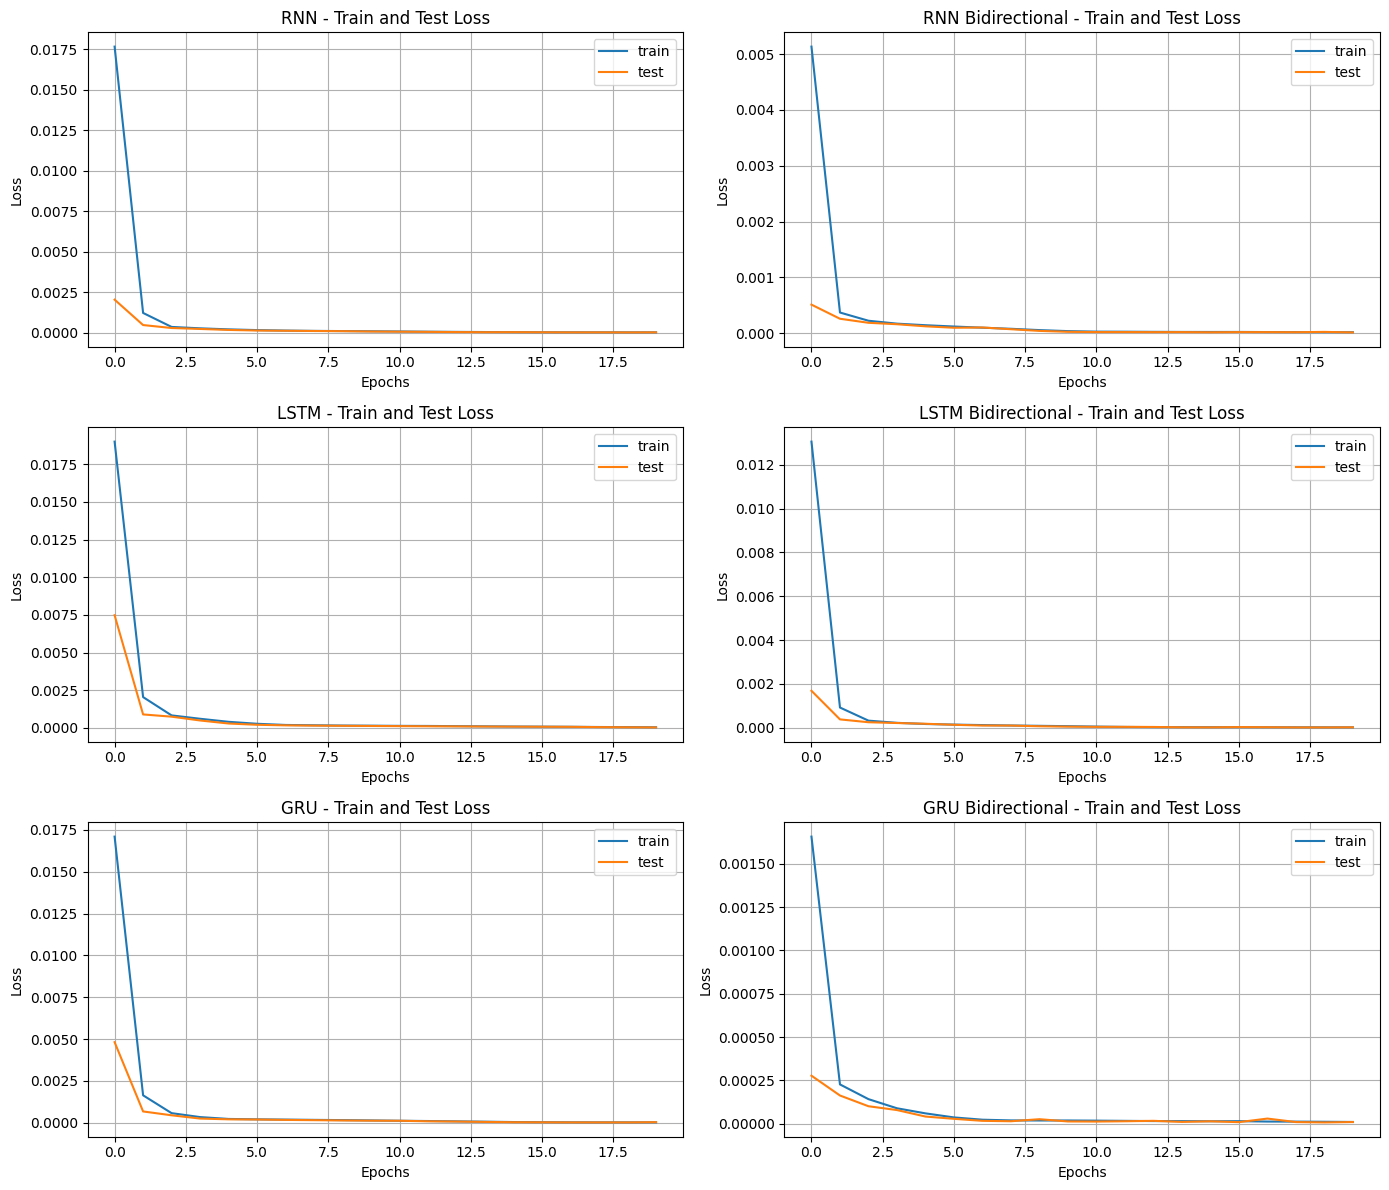

In [41]:
plt.figure(figsize=(14, 12))

titles = [
    "RNN",
    "RNN Bidirectional",
    "LSTM",
    "LSTM Bidirectional",
    "GRU",
    "GRU Bidirectional"
]

for idx,name in enumerate(titles):
  plt.subplot(3, 2, idx + 1)
  sns.lineplot(train_losses[idx], label='train')
  sns.lineplot(test_losses[idx],  label='test')
  plt.xlabel("Epochs")
  plt.ylabel("Loss")
  plt.title(f"{name} - Train and Test Loss")
  plt.legend()
  plt.grid(True)

plt.tight_layout()

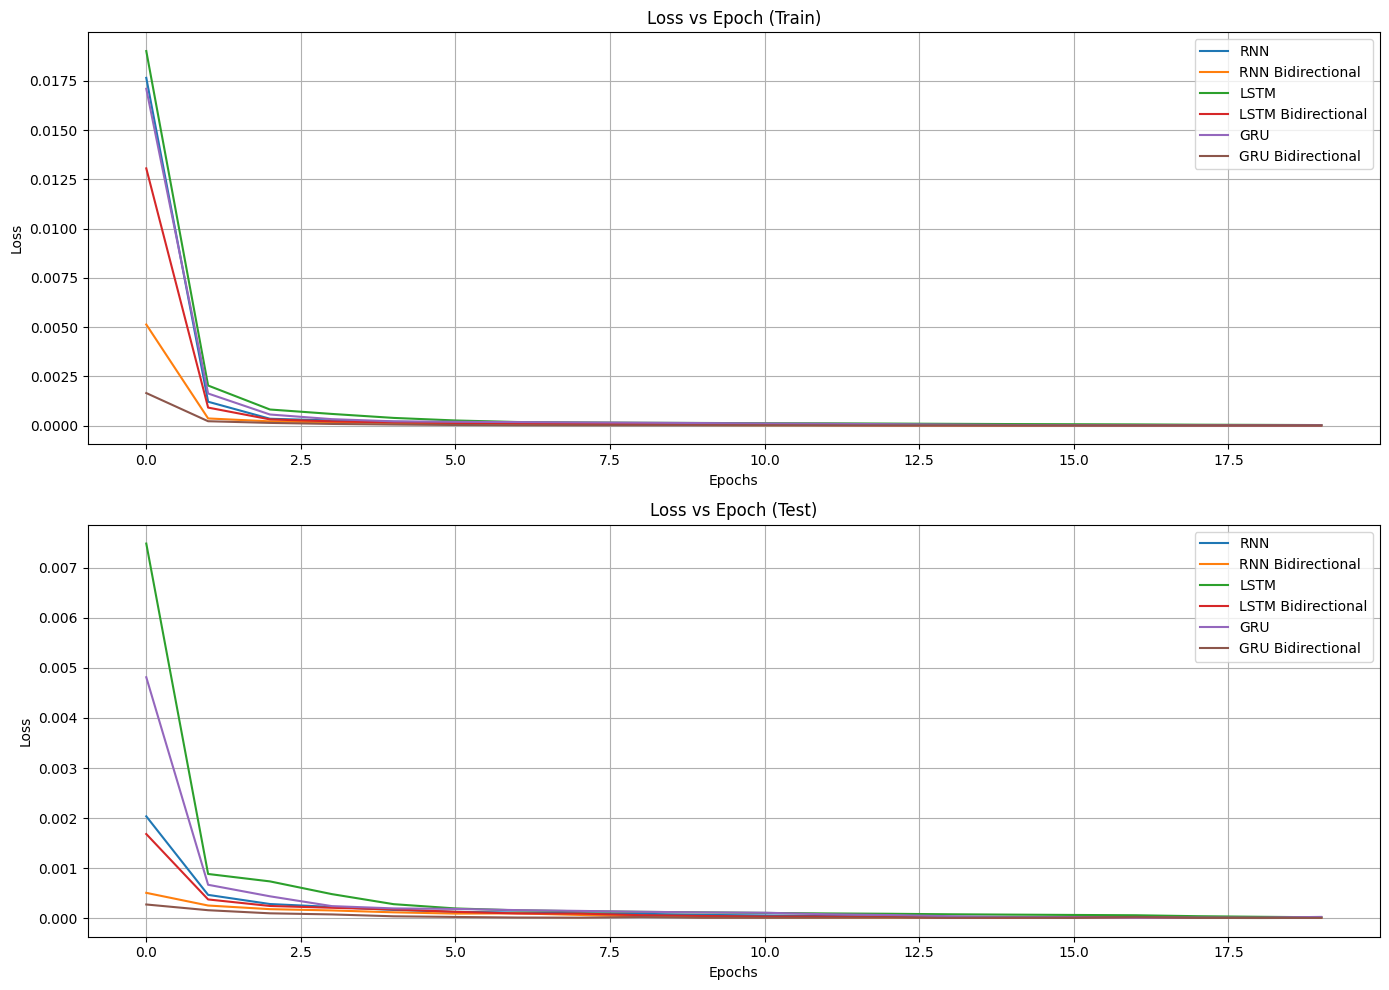

In [42]:
plt.figure(figsize=(14, 10))

plt.subplot(2, 1, 1)
for idx,name in enumerate(titles):
  sns.lineplot(train_losses[idx], label=name)
  plt.xlabel("Epochs")
  plt.ylabel("Loss")

plt.title("Loss vs Epoch (Train)")
plt.legend()
plt.grid(True)

plt.subplot(2, 1, 2)
for idx,name in enumerate(titles):
  sns.lineplot(test_losses[idx],  label=name)
  plt.xlabel("Epochs")
  plt.ylabel("Loss")

plt.title("Loss vs Epoch (Test)")
plt.legend()
plt.grid(True)
plt.tight_layout()

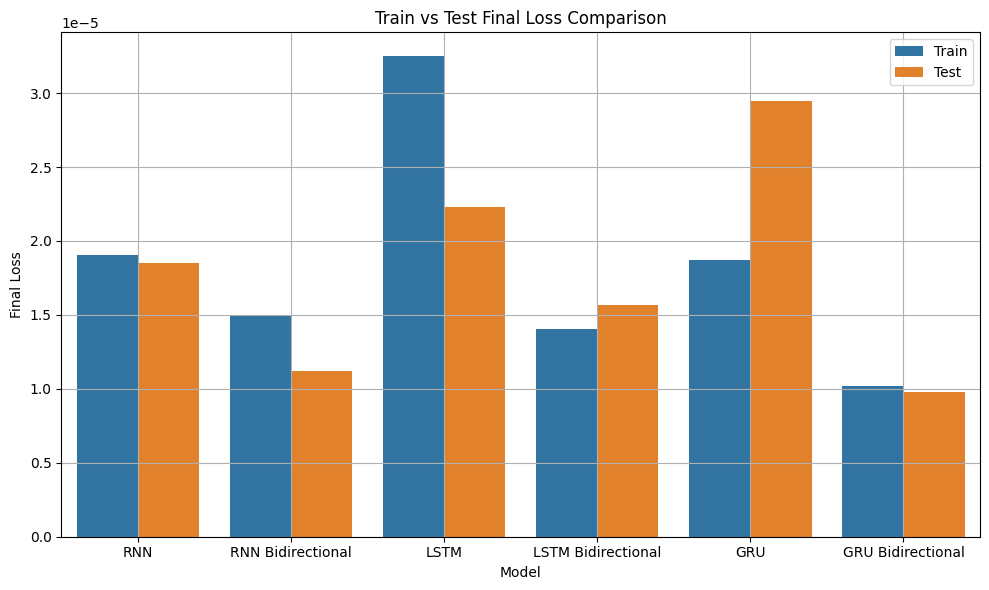

In [43]:
train_final = torch.tensor(train_losses)[:,-1].detach().cpu().numpy()
test_final  = torch.tensor(test_losses)[:,-1].detach().cpu().numpy()

data = {
    "Model": titles * 2,
    "Loss Type": ["Train"] * len(titles) + ["Test"] * len(titles),
    "Final Loss": list(train_final) + list(test_final)
}
df = pd.DataFrame(data)

plt.figure(figsize=(10, 6))
sns.barplot(x="Model", y="Final Loss", hue="Loss Type", data=df)
plt.title("Train vs Test Final Loss Comparison")
plt.xlabel("Model")
plt.ylabel("Final Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()

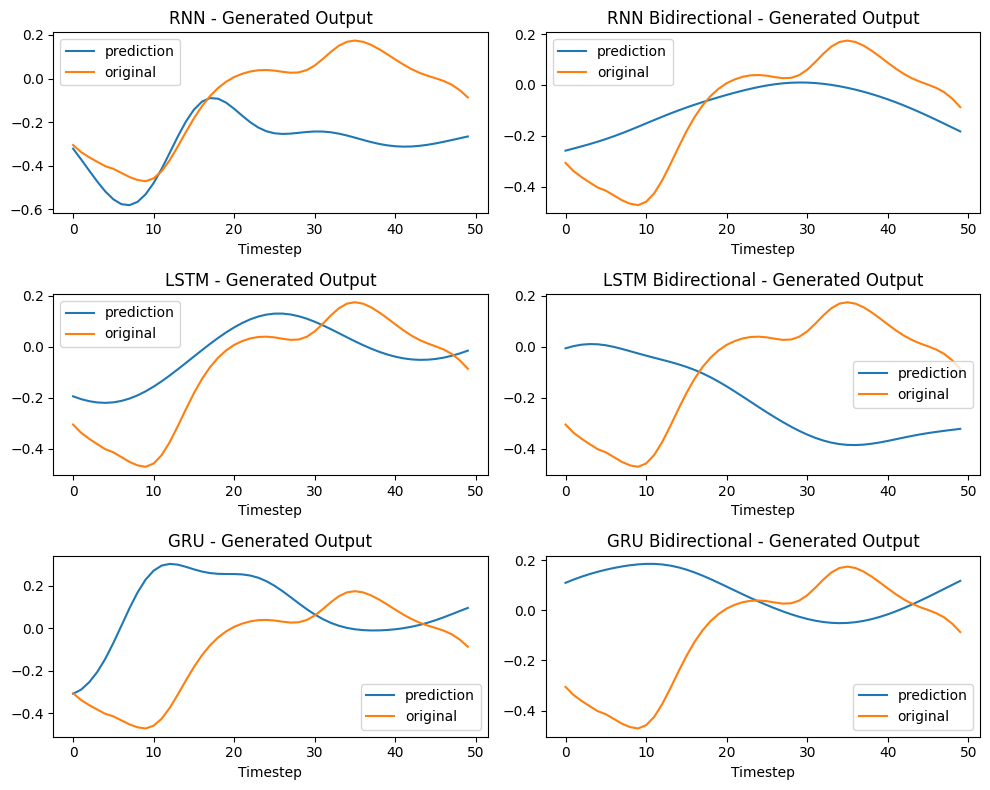

In [61]:
with torch.no_grad():
  plt.figure(figsize=(10, 8))

  # Extract first 8 timesteps as input
  data_vals = pd.read_csv("data.txt", header=None).values
  original_data = torch.tensor(data_vals)
  start_timestep = 0
  input = list(original_data[start_timestep:start_timestep + 8])

  for model_idx, model in enumerate(final_models):
    # Get 50 next 50 timesteps of model output
    res = []
    time_steps = 50

    for i in range(time_steps):
      input_tensor = torch.tensor(input).view(1, -1)
      output = model(input_tensor.float().to(DEVICE))
      res.append(output.item())
      input.append(output.item())
      input.pop(0)

    plt.subplot(3, 2, model_idx + 1)
    plt.plot(res, label='prediction')
    plt.plot([i.item() for i in original_data[start_timestep + 8:start_timestep + time_steps + 8]],
                                                label='original')

    plt.title(f"{titles[model_idx]} - Generated Output")
    plt.xlabel("Timestep")
    plt.legend()

  plt.tight_layout();